## Modeul Import

In [1]:
# self defined Modules
from myModules.utils.data.DataLoader import DataLoader
from myModules.utils.merge.mergeOverPeriod import merge
from myModules.preprocess import cleaning, tagging, removeStopWords_ST, tokenizing_ST, extract_some_pos_ST
from myModules.TopicModeling.LDA.ldaModeling import buildDTM, topicWords, visualizeLDA

# General Modules
import pandas as pd
import numpy as np

import warnings
from tqdm.notebook import tqdm

warnings.filterwarnings('ignore')

# Read File
import glob

# NLP
import nltk
from nltk.tokenize import TreebankWordTokenizer
from apyori import apriori
from nltk import FreqDist
from gensim import models
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Data Load

In [2]:
DATA_ROOT = './Data/3구간/'

PERIOD_1 = DATA_ROOT + '1시기/1시기_ST/'
PERIOD_2 = DATA_ROOT + '2시기/2시기_ST/'
PERIOD_3 = DATA_ROOT + '3시기/3시기_ST/'

RESULT_ROOT = './Result/3구간/'

RESULT_1 = RESULT_ROOT + '/1시기/ST/'
RESULT_2 = RESULT_ROOT + '/2시기/ST/'
RESULT_3 = RESULT_ROOT + '/3시기/ST/'

In [3]:
files_1 = glob.glob(PERIOD_1+'*.txt')
files_2 = glob.glob(PERIOD_2+'*.txt')
files_3 = glob.glob(PERIOD_3+'*.txt')

texts_1 = DataLoader(files_1, mode='ST')
texts_2 = DataLoader(files_2, mode='ST')
texts_3 = DataLoader(files_3, mode='ST')

## PreProcess

### 3-1. Data Cleaning

In [4]:
cleaned_1 = cleaning(texts_1, mode='ST')
cleaned_2 = cleaning(texts_2, mode='ST')
cleaned_3 = cleaning(texts_3, mode='ST')

### 3-2. Tokenizing

In [5]:
tokenizer = TreebankWordTokenizer()

tokenized_1 = tokenizing_ST(cleaned_1, tokenizer)
tokenized_2 = tokenizing_ST(cleaned_2, tokenizer)
tokenized_3 = tokenizing_ST(cleaned_3, tokenizer)

### 3-3. Remove StopWords

In [6]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords = nltk.corpus.stopwords.words('english')
new_stopwords = ['would', 'could', 'might', 'need', 'can', 'must', \
    'e', 'one', 'two', 'upon', 'may', 'perhaps', 'living', 'seem', 'also', 'ii', 'ofthe',
    'also', 'much', 'therefore']

wo_stopword_1 = removeStopWords_ST(tokenized_1, stopwords, new_stopwords)
wo_stopword_2 = removeStopWords_ST(tokenized_2, stopwords, new_stopwords)
wo_stopword_3 = removeStopWords_ST(tokenized_3, stopwords, new_stopwords)

### 3-4. Tagging

In [7]:

tagList = [['noun', ['NN','NNS','NNP','NNPS'], ['NNG','NNB','NNP','NNM']], \
    ['pronoun', ['PRP','WP','PRP'], ['NP']],
    ['verb', ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'], ['VV', 'VXV', 'VCP']],
    ['adjective', ['JJ', 'JJR', 'JJS'], ['VA', 'VXA', 'VCN']],
    ['adverb', ['RB', 'RBR', 'RBS', 'WRB', 'EX', 'RP'], ['MAG']],
    ['prep&conj', ['TO', 'IN', 'CC'], ['MAC']],
    ['determiner', ['DT', 'PDT', 'WDT'], ['MDT', 'MDN']],
    ['interjection',['UH'], ['IC']],
    ['number', ['CD'], ['NR', 'ON']],
    ['foreignW', ['FW'],['OL']],
    ['modal',['MD'],[]],
    ['josa', [], ['JC', 'JK', 'JKC', 'JKG', 'JKI', 'JKM', 'JKO', 'JKQ', 'JKS', 'JX']],
    ['possesiveS', ['POS'], []],
    ['others',['LS'], ['EPH', 'EPT', 'EPP', 'EFN', 'EFQ', 'EFO', 'EFA', 'EFI', 'EFR', 'ECE', 'ECD', 'ECS', 'ETN', 'ETD', 'XPN', 'XPV', 'XSN', 'XSV', 'XSA', 'XR', 'UN', 'OH']]]

tagList = pd.DataFrame(tagList)
tagList.columns = ['POS', 'Eng_tag', 'Kor_tag']

In [8]:
tagged_1 = tagging(wo_stopword_1, mode='ST')
tagged_2 = tagging(wo_stopword_2, mode='ST')
tagged_3 = tagging(wo_stopword_3, mode='ST')

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

In [9]:
extracted_1 = extract_some_pos_ST(articles=tagged_1, tagList=tagList, pos_list=['noun', 'verb', 'adjective'])
extracted_2 = extract_some_pos_ST(articles=tagged_2, tagList=tagList, pos_list=['noun', 'verb', 'adjective'])
extracted_3 = extract_some_pos_ST(articles=tagged_3, tagList=tagList, pos_list=['noun', 'verb', 'adjective'])

## 4. Topic Modeling

### 4-1. parameter tuning & LDA modeling

- topic num : 가설로 설정한 topic의 갯수
    1. Topic Coherence
        - 주제의 일관성 측정
        - 모델링이 잘 될수록 한 주제 안에는 의미론적으로 유사한 단어가 많이 모여있게 됨.
        - 높을수록 의미론적 일관성이 높다.
        - Coherence가 높아지면 Monotonic 해지는 문제점이 생긴다.
        - coherence가 너무 높아지면 정보의 양이 줄어들고, coherence가 너무 낮으면 정보들의 연관성이 없어져 분석의 의미가 없다.
    2. Perplexity   
        - Coherence가 이 data에서 topic number가 늘어날수록 거의 같이 늘어나는 경향을 보임
        - 따라서 다른 평가기준도 함께 고려해야겠다는 생각에 추가
        - 작아질수록 토픽모델이 문서를 잘 반영한다.

- lda modeling 결과를 시각화해 보았을 때, 10이상으로 넘어가면 할당되지 않는 빈 id들이 발견되었습니다.
    - 따라서 시험할 k값의 범위를 1~10까지 자연수로 설정하였습니다.


In [10]:
NUM_TOPIC_WORDS = 30
PASSES = 30
ITERATIONS = 400
EVAL_EVERY = None
random_state = 42

In [11]:
class BestLDAPram:
    def __init__(self, passes=30, iterations=400, eval_every=None, random_state=42):
        self.passes = passes
        self.iterations = iterations
        self.eval_every = eval_every
        self.random_state = random_state
    
    def calc_coherence(self, corpus, dictionary, alpha='auto', eta='auto'):
        self.coherences = []
        self.num_topics_c = []

        for ntopics in tqdm(range(1, 11), desc='Topic Coherence'):
            model = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=ntopics, \
                iterations=self.iterations, passes=self.passes, \
                alpha=alpha, eta=eta, eval_every=self.eval_every, random_state=self.random_state)
            
            cm = CoherenceModel(model=model, corpus=corpus, coherence='u_mass')
            coherence = cm.get_coherence()

            self.coherences.append(coherence)
            self.num_topics_c.append(ntopics)
    
    def calc_perplexity(self, corpus, dictionary, alpha='auto', eta='auto'):
        self.perplexities = []
        self.num_topics_p = []

        for ntopics in tqdm(range(1, 11), desc='Perpelxity'):
            model = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=ntopics, \
                iterations=self.iterations, passes=self.passes, \
                alpha=alpha, eta=eta, eval_every=self.eval_every, random_state=self.random_state)
            
            perplexity = model.log_perplexity(corpus)
            self.perplexities.append(perplexity)
            self.num_topics_p.append(ntopics)
    
    def calc_alpha(self, corpus, dictionary, num_topics, eta='auto'):
        self.alphas = []
        self.coherences_a = []

        for i in tqdm(range(0, 11), desc='alpha'):
            alpha = i * 0.001
            model = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, \
                iterations=self.iterations, passes=self.passes, \
                alpha=alpha, eta=eta, eval_every=self.eval_every, random_state=self.random_state)

            cm = CoherenceModel(model=model, corpus=corpus, coherence='u_mass')
            coherence = cm.get_coherence()

            self.coherences_a.append(coherence)
            self.alphas.append(alpha)
    
    def calc_eta(self, corpus, dictionary, num_topics, alpha='auto'):
        self.etas = []
        self.coherences_e = []

        for i in tqdm(range(0, 11), desc='eta'):
            eta = i * 0.01
            model = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, \
                iterations=self.iterations, passes=self.passes, \
                alpha=alpha, eta=eta, eval_every=self.eval_every, random_state=self.random_state)
        
            cm = CoherenceModel(model=model, corpus=corpus, coherence='u_mass')
            coherence = cm.get_coherence()

            self.coherences_e.append(coherence)
            self.etas.append(eta)
    
    def plot_coherence(self, title='Coherence per Topic Num', root='./'):
        plt.figure()

        plt.plot(self.num_topics_c, self.coherences)

        plt.xlabel('Topic Number')
        plt.ylabel('Coherence')

        plt.title(title)
        plt.savefig(root+title+'.png')
        plt.show()
    
    def plot_perplexity(self, title='Perplexity per Topic Num', root='./'):
        plt.figure()

        plt.plot(self.num_topics_p, self.perplexities)

        plt.xlabel('Topic Number')
        plt.ylabel('Perplexity')

        plt.title(title)
        plt.savefig(root+title+'.png')
        plt.show()

    def plot_alpha(self, title='Coherence per alpha', root='./'):
        plt.figure()

        plt.plot(self.alphas, self.coherences_a)

        plt.xlabel('alpha')
        plt.ylabel('coherence')

        plt.title(title)
        plt.savefig(root+title+'.png')
        plt.show()
    
    def plot_eta(self, title='Coherence per eta', root='./'):
        plt.figure()

        plt.plot(self.etas, self.coherences_e)

        plt.xlabel('eta')
        plt.ylabel('coherence')

        plt.title(title)
        plt.savefig(root+title+'.png')
        plt.show()

#### Period 1

In [12]:
lda_param = BestLDAPram(passes=PASSES, iterations=ITERATIONS, eval_every=EVAL_EVERY)

In [13]:
Corp, Dict = buildDTM(wo_stopword_1)

##### Coherence와 Perplexity로 최적의 topic number 구하기

Topic Coherence:   0%|          | 0/10 [00:00<?, ?it/s]

Perpelxity:   0%|          | 0/10 [00:00<?, ?it/s]

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


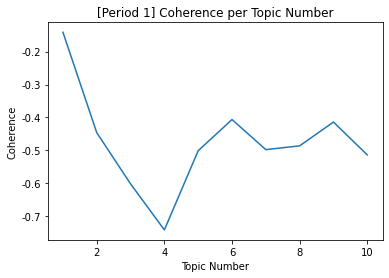

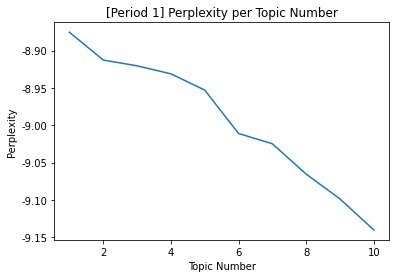

In [14]:
lda_param.calc_coherence(corpus=Corp, dictionary=Dict)
lda_param.calc_perplexity(corpus=Corp, dictionary=Dict)

lda_param.plot_coherence('[Period 1] Coherence per Topic Number', root=RESULT_1)
lda_param.plot_perplexity('[Period 1] Perplexity per Topic Number', root=RESULT_1)

##### 최적의 Topic number를 이용하여 최적의 alpha와 eta값 추정하기

alpha:   0%|          | 0/11 [00:00<?, ?it/s]

eta:   0%|          | 0/11 [00:00<?, ?it/s]

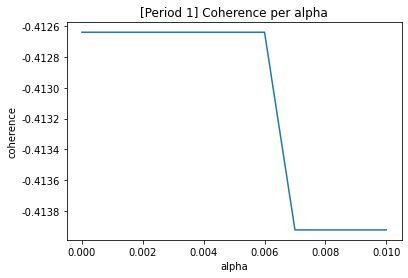

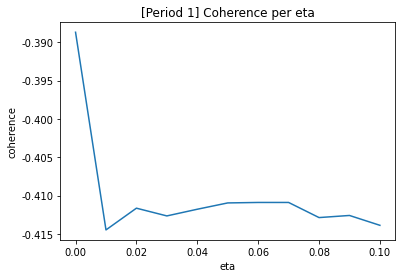

In [15]:
NUM_TOPICS = 9

lda_param.calc_alpha(corpus=Corp, dictionary=Dict, num_topics=NUM_TOPICS)
lda_param.calc_eta(corpus=Corp, dictionary=Dict, num_topics=NUM_TOPICS)

lda_param.plot_alpha(title='[Period 1] Coherence per alpha', root=RESULT_1)
lda_param.plot_eta(title='[Period 1] Coherence per eta', root=RESULT_1)

In [16]:
NUM_TOPICS = 9
ALPHA = 0.002
ETA = 0.07

Corp, Dict = buildDTM(wo_stopword_1)
model = models.ldamodel.LdaModel(Corp, id2word=Dict, num_topics=NUM_TOPICS, alpha=ALPHA, eta=ETA, random_state=random_state)
topicdf = topicWords(model, NUM_TOPIC_WORDS)
topicdf.to_csv(RESULT_1+'[Period 1] topic words.csv', index=False)
data = visualizeLDA(model, Corp, Dict)

data

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.005459 -0.002539       1        1  32.626871
5      0.002003  0.008146       2        1  18.671732
4      0.001203  0.001336       3        1  13.296402
3     -0.007480 -0.004094       4        1  10.455179
2     -0.000377 -0.003811       5        1  10.075499
1     -0.004071  0.004788       6        1   8.295605
0      0.006152 -0.004723       7        1   6.338696
8      0.003349 -0.001448       8        1   0.239950
7      0.004679  0.002344       9        1   0.000066, topic_info=          Term        Freq       Total Category  logprob  loglift
3863    soviet  160.000000  160.000000  Default  30.0000  30.0000
948        new   97.000000   97.000000  Default  29.0000  29.0000
1615       war  104.000000  104.000000  Default  28.0000  28.0000
49    american  103.000000  103.000000  Default  27.0000  27.0000
1040    people   91.000000   91.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
519      first    0.000028   47.936739   Topic9  -6.5795  -0.1085
461      every    0.000030   55.644181   Topic9  -6.5274  -0.2055
1515      time    0.000030   57.580664   Topic9  -6.5199  -0.2322
821       like    0.000029   52.807648   Topic9  -6.5529  -0.1787
880        men    0.000029   52.864137   Topic9  -6.5683  -0.1951

[760 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
6115      1  0.420636   acres
6115      2  0.210318   acres
6115      3  0.210318   acres
1698      1  0.203779  across
1698      2  0.203779  across
...     ...       ...     ...
1673      3  0.128133   young
1673      4  0.064067   young
1673      5  0.064067   young
1673      6  0.064067   young
1673      7  0.064067   young

[1495 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 6, 5, 4, 3, 2, 1, 9, 8])

#### Period 2

In [17]:
lda_param = BestLDAPram(passes=PASSES, iterations=ITERATIONS, eval_every=EVAL_EVERY)

In [18]:
Corp, Dict = buildDTM(wo_stopword_2)

##### Coherence와 Perplexity로 최적의 topic number 구하기

Topic Coherence:   0%|          | 0/10 [00:00<?, ?it/s]

Perpelxity:   0%|          | 0/10 [00:00<?, ?it/s]

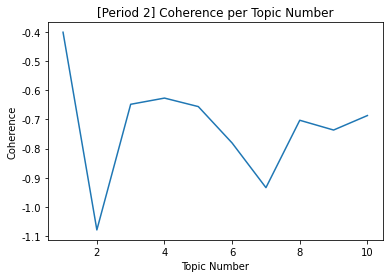

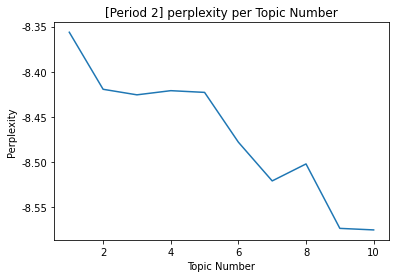

In [19]:
lda_param.calc_coherence(corpus=Corp, dictionary=Dict)
lda_param.calc_perplexity(corpus=Corp, dictionary=Dict)

lda_param.plot_coherence('[Period 2] Coherence per Topic Number', root=RESULT_2)
lda_param.plot_perplexity('[Period 2] perplexity per Topic Number', root=RESULT_2)


alpha:   0%|          | 0/11 [00:00<?, ?it/s]

eta:   0%|          | 0/11 [00:00<?, ?it/s]

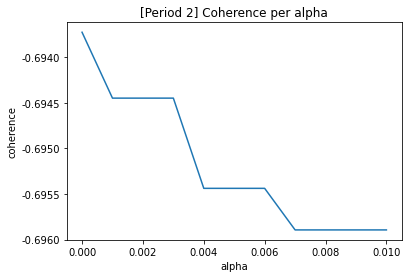

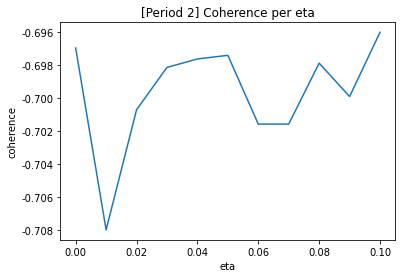

In [20]:
NUM_TOPICS = 8

lda_param.calc_alpha(corpus=Corp, dictionary=Dict, num_topics=NUM_TOPICS)
lda_param.calc_eta(corpus=Corp, dictionary=Dict, num_topics=NUM_TOPICS)

lda_param.plot_alpha('[Period 2] Coherence per alpha', root=RESULT_2)
lda_param.plot_eta('[Period 2] Coherence per eta', root=RESULT_2)

In [21]:
NUM_TOPICS = 8
ALPHA = 0.002
ETA = 0.05

Corp, Dict = buildDTM(wo_stopword_2)
model = models.ldamodel.LdaModel(Corp, id2word=Dict, num_topics=NUM_TOPICS, alpha=ALPHA, eta=ETA, random_state=random_state)
topicdf = topicWords(model, NUM_TOPIC_WORDS)
topicdf.to_csv(RESULT_2+'[Period 2] topic words.csv', index=False)
data = visualizeLDA(model, Corp, Dict)

data

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.016016 -0.000298       1        1  43.207836
1      0.007308  0.003370       2        1  35.748505
2      0.011304 -0.000931       3        1   7.904675
5      0.003227  0.008616       4        1   7.088513
7     -0.003817 -0.007116       5        1   3.619518
4      0.000624  0.010395       6        1   2.430719
0      0.000458 -0.011189       7        1   0.000117
6     -0.003088 -0.002846       8        1   0.000117, topic_info=          Term        Freq       Total Category  logprob  loglift
1308       war  142.000000  142.000000  Default  30.0000  30.0000
1102    soviet   96.000000   96.000000  Default  29.0000  29.0000
1266    united  128.000000  128.000000  Default  28.0000  28.0000
1117    states  122.000000  122.000000  Default  27.0000  27.0000
4759  japanese   70.000000   70.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
1262     union    0.000036   44.513389   Topic8  -6.3218  -0.3643
1358     years    0.000033   35.158197   Topic8  -6.4074  -0.2139
1346     world    0.000042   75.208427   Topic8  -6.1838  -0.7508
50    american    0.000036   63.406347   Topic8  -6.3202  -0.7165
874      peace    0.000035   55.280182   Topic8  -6.3489  -0.6080

[672 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
2094      2  0.894298       aa
3873      1  0.470510   accept
3873      2  0.313673   accept
3873      3  0.156837   accept
3873      4  0.156837   accept
...     ...       ...      ...
1358      3  0.085329    years
1358      4  0.085329    years
1358      5  0.028443    years
1358      6  0.028443    years
3539      1  0.735019  zhdanov

[878 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 3, 6, 8, 5, 1, 7])

#### Period 3

In [22]:
lda_param = BestLDAPram(passes=PASSES, iterations=ITERATIONS, eval_every=EVAL_EVERY)

In [23]:
Corp, Dict = buildDTM(wo_stopword_3)

Topic Coherence:   0%|          | 0/10 [00:00<?, ?it/s]

Perpelxity:   0%|          | 0/10 [00:00<?, ?it/s]

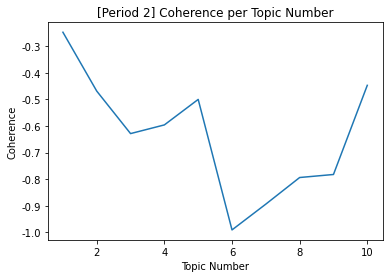

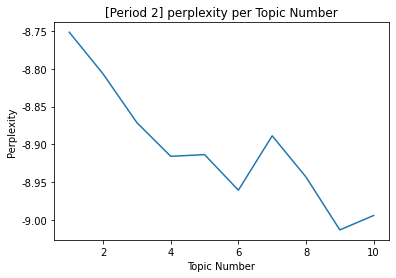

In [24]:
lda_param.calc_coherence(corpus=Corp, dictionary=Dict)
lda_param.calc_perplexity(corpus=Corp, dictionary=Dict)

lda_param.plot_coherence('[Period 2] Coherence per Topic Number', root=RESULT_3)
lda_param.plot_perplexity('[Period 2] perplexity per Topic Number', root=RESULT_3)

alpha:   0%|          | 0/11 [00:00<?, ?it/s]

eta:   0%|          | 0/11 [00:00<?, ?it/s]

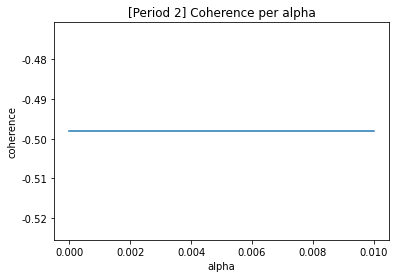

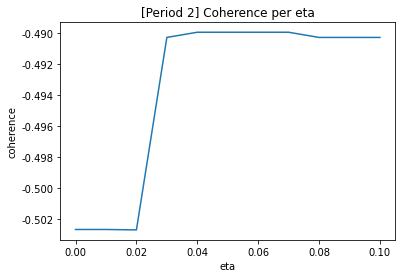

In [25]:
NUM_TOPICS = 5

lda_param.calc_alpha(corpus=Corp, dictionary=Dict, num_topics=NUM_TOPICS)
lda_param.calc_eta(corpus=Corp, dictionary=Dict, num_topics=NUM_TOPICS)

lda_param.plot_alpha(title='[Period 2] Coherence per alpha', root=RESULT_3)
lda_param.plot_eta(title='[Period 2] Coherence per eta', root=RESULT_3)

In [26]:
NUM_TOPICS = 5
ALPHA = 0.005
ETA = 0.04

Corp, Dict = buildDTM(wo_stopword_3)
model = models.ldamodel.LdaModel(Corp, id2word=Dict, num_topics=NUM_TOPICS, alpha=ALPHA, eta=ETA, random_state=random_state)
topicdf = topicWords(model, NUM_TOPIC_WORDS)
topicdf.to_csv(RESULT_3+'[Period 3] topic words.csv', index=False)
data = visualizeLDA(model, Corp, Dict)

data

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.008625  0.001990       1        1  52.312251
0      0.001117  0.002450       2        1  32.063067
1     -0.006604 -0.004942       3        1  12.339675
3     -0.004418  0.007480       4        1   3.284814
2      0.001279 -0.006978       5        1   0.000194, topic_info=           Term        Freq       Total Category  logprob  loglift
1159        war  151.000000  151.000000  Default  30.0000  30.0000
1696     soviet  139.000000  139.000000  Default  29.0000  29.0000
796   president  135.000000  135.000000  Default  28.0000  28.0000
670          mr  101.000000  101.000000  Default  27.0000  27.0000
778      policy   93.000000   93.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
1518     moscow    0.000088   50.241576   Topic5  -6.4446  -0.1014
676     nations    0.000086   53.589906   Topic5  -6.4680  -0.1893
1757       told    0.000078   45.283759   Topic5  -6.5611  -0.1140
2401       said    0.000081   62.102869   Topic5  -6.5293  -0.3980
606        made    0.000081   66.055179   Topic5  -6.5255  -0.4559

[461 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
28        1  0.485079   advisers
28        2  0.323386   advisers
28        3  0.161693   advisers
28        4  0.080846   advisers
2629      1  0.603645  agreement
...     ...       ...        ...
1199      3  0.124595        yet
1199      4  0.062298        yet
3734      1  0.588479      zones
3734      2  0.147120      zones
3734      3  0.147120      zones

[681 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 2, 4, 3])